In [1]:
!pip install ht CoolProp fluids xlrd xlwt

     |████████████████████████████████| 899 kB 4.5 MB/s 
     |████████████████████████████████| 4.2 MB 12.9 MB/s 
     |████████████████████████████████| 2.9 MB 61.9 MB/s 
     |████████████████████████████████| 96 kB 5.1 MB/s 
     |████████████████████████████████| 99 kB 7.8 MB/s 
  Created wheel for fluids: filename=fluids-1.0.7-py3-none-any.whl size=1481215 sha256=c0a2d75355dc2daab845fa169a7ddffc1e060c0ea753ccdac68f0d00ca8faf1a
  Stored in directory: /root/.cache/pip/wheels/e8/17/90/b2088060f2bc3744a2ace45369f20f1d13a92b5968fe2de822
  Created wheel for ht: filename=ht-1.0.1-py3-none-any.whl size=837891 sha256=61cc929b0283e8d74349a04b5e32c2914841b172e439bb0b43e472d13adece4a
  Stored in directory: /root/.cache/pip/wheels/27/7f/fd/663f7442317cb8408db8d87f256bb804274910c8f1c081cad1
Successfully built fluids ht


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xlwt as xw
lista_data = []
import matplotlib.pyplot as plt
import ht,fluids,os
import CoolProp as cp
from IPython.display import Latex
from shutil import copyfile
copyfile(src = "../input/prop-fluidos-intercambiadores/prop_fluidos_intercambiadores.py", dst = "../working/prop_fluidos_intercambiadores.py")
from prop_fluidos_intercambiadores import fluido_intercambiador
#data_excel = pd.read_excel('../input/data-eduardo-leon-rev1/Calculo calentador aire mandioca Rev1.xls',sheet_name=1)

## Intercambiador de Calor
#### HIPOTESIS DE CALCULO:


1. Intercambiador de calor tubular de tubos lisos (sin aletas)
2. Flujo de aire dentro de tubos
3. Flujo cruzado de gases externo a tubos
4. Distribución de tubos alineados

Se propone un paso de tubos p = 1.5 D. En intercambiadores casco y tubo, lo usual es encontrar pasos p= D o p = 1.3D. Ver pej 
- Shah, R. K., & Sekulic, D. P. (2003). Fundamentals of heat exchanger design. John Wiley & Sons. 
- Cao, E. (2010). Heat transfer in process engineering. McGraw-Hill Education. (pags 509-522)

In [3]:
#constantes de calculo
g = 9.8; cal2joule = 4.184
###########################################################
#           DATOS  del Intercambiador  
#
###########################################################
# Definición de Flujos
Gases = fluido_intercambiador('Gases combustion') 
Aire = fluido_intercambiador('Aire')
# Temperaturas
Gases.temp_entrada = 400 
Gases.temp_salida = 150
Aire.temp_entrada = 20
Aire.temp_salida = 70
Gases.caudal = 0.15*1.3/Gases.rho  #kg/s un 30% mayor a la condicion de diseño del horno
Q = Gases.rho*Gases.cp*(Gases.temp_entrada-Gases.temp_salida)*Gases.caudal

Aire.caudal = Q/ (Aire.rho*(Aire.temp_salida-Aire.temp_entrada)*Aire.cp  )
Gases.calor_intercambiado, Aire.calor_intercambiado = [Q,Q]

# Geometría del Intercambiador
Tubo_dext = 60.3e-3
Tubo_esp = 2*1e-3
Tubo_dint = Tubo_dext-Tubo_esp*2
Tubo_long = 1.45   ### pregunta de corte 
paso_tubos = 1.25*Tubo_dext
Ncarcasa = 1
Rf = 4e-3  #factor de ensuciamiento. Ver Cao pag 524

Observación: Se propone un paso de tubos p = 1.5 D. En intercambiadores casco y tubo, lo usual es encontrar pasos p= D o p = 1.3D. Ver pej 
- Shah, R. K., & Sekulic, D. P. (2003). Fundamentals of heat exchanger design. John Wiley & Sons. 
- Cao, E. (2010). Heat transfer in process engineering. McGraw-Hill Education. (pags 509-522)

Pero la elección p = 1.5D tiene razones de facilidad en la limpieza, pej.

### Eficiencia térmica. Calor Intercambiado.

In [4]:
#Capacidad Térmica Mínima
Cmin = np.min((Aire.cp*Aire.caudal*Aire.rho,Gases.cp*Gases.caudal*Gases.rho))
#Mayor Salto Térmico del sistema
DeltaT_max = Gases.temp_entrada-Aire.temp_entrada
#Calor Máximo disponible
Qmax = Cmin*DeltaT_max
#ficiencia térmica
eficiencia = Q/Qmax

 
print(f'Capacidad Térmica Mínima Cmin = %.1f W/K'%Cmin)
print(f'Calor Máximo disponible Qmax=%.1f kW'%(Qmax*1e-3))
print(f'Calor Intercambiado = {Q/cal2joule*1e-3*3600:.1f} kcal/h')
print(f'Eficiencia térmica del equipo = %.2f'%eficiencia)


Capacidad Térmica Mínima Cmin = 202.7 W/K
Calor Máximo disponible Qmax=77.0 kW
Calor Intercambiado = 43606.9 kcal/h
Eficiencia térmica del equipo = 0.66


## LMTD, área y Coeficiente Global 


In [5]:
LMTD = ht.LMTD(Tci=Aire.temp_entrada, Tco=Aire.temp_salida, Thi=Gases.temp_entrada, Tho=Gases.temp_salida)

ht.Ft_aircooler(Tci=Aire.temp_entrada, Tco=Aire.temp_salida, Thi=Gases.temp_entrada,
                Tho=Gases.temp_salida, Ntp=1, rows=6)

Ft = ht.Ft_aircooler(Tci=Aire.temp_entrada, Tco=Aire.temp_salida, Thi=Gases.temp_entrada,Tho=Gases.temp_salida, Ntp=1, rows=6)

#######################
UA = Q/(LMTD*Ft)
Upropuesto = 19
Apropuesta = UA/Upropuesto
Ntubos_0_0  = np.int(Apropuesta / (np.pi*Tubo_dext*Tubo_long))  ## numero de tubos inicial
Ntubos_0 = np.ceil(Ntubos_0_0/4)*4
#Ntubos_0 = Ntubos_0_0
Areal = Ntubos_0*(np.pi*Tubo_dext*Tubo_long)
print('Temperatura logaritmica media %.1f C'%LMTD)
print('Número de Unidades de Transferencia (Nut) = %.2f'%(UA/Cmin))
print('G_Gases =%.1f m3/s'%Gases.caudal)
print('G_Aire =%.1f m3/s '%Aire.caudal)
print('Area propuesta =%.1f'%Apropuesta)
print('Area real =%.1f'%Areal)
print('Numero de tubos %0d'%Ntubos_0)

Npasostubos = 1
Aire.area =  Tubo_dint**2/4*np.pi*Ntubos_0/(Npasostubos+1)
Aire.long = Tubo_dint
Aire.veloc = Aire.caudal / Aire.area
Aire.Reynolds()
#Npasotubos =  Re_design*(np.pi*Tubo_dext-Tubo_esp*2*Ntubos_0*m ) / (4*m_t)

Temperatura logaritmica media 214.7 C
Número de Unidades de Transferencia (Nut) = 1.20
G_Gases =0.3 m3/s
G_Aire =0.9 m3/s 
Area propuesta =12.8
Area real =13.2
Numero de tubos 48


In [6]:
#nfilas será normal al escurrimiento de gases
#ncolumndas sera paralelo al escurrimiento de gases
###########################################################
# Determinacion de Area de pasaje del aire por la carcasa
# alrededor del paquete de tubos
###########################################################
#Tubo_area_ext = Tubo_dext**2/4*np.pi
carcasa_huelgo = 20e-3

#Atencion ponemos esto a MANO##
nfilas = 6
###############################

ncolumnas = Ntubos_0/nfilas

carcasa_xmax,carcasa_ymax = [paso_tubos*(ncolumnas-1)+carcasa_huelgo*2+Tubo_dext,
                                                       paso_tubos*(nfilas-1)+carcasa_huelgo*2+Tubo_dext]
carcasa_area = carcasa_xmax*carcasa_ymax

Veloc_banco_entrada  = Gases.caudal/(carcasa_xmax*Tubo_long)
Veloc_banco_max = Veloc_banco_entrada*paso_tubos/(paso_tubos-Tubo_dext) #esta expresión no toma en cuenta el area entre tubo y carcasa (huelgo)

Gases.area = (carcasa_xmax-Tubo_dext*ncolumnas)*Tubo_long
Gases.long = Tubo_dext
Gases.veloc = Gases.caudal  / Gases.area
print('Area de pasaje de Gases %.3f m2'%Gases.area)
print('Velocidad de Gases %.3f m/s'%Gases.veloc)
print('Velocidad de Banco max %.3f m/s'%Veloc_banco_max)

Area de pasaje de Gases 0.211 m2
Velocidad de Gases 1.435 m/s
Velocidad de Banco max 1.663 m/s


In [7]:
Gases.Reynolds() 
Re_banco_tubos = Veloc_banco_max*Gases.long/Gases.nu
Re = Gases.Re
pitch_parallel,pitch_normal = [paso_tubos,paso_tubos]
Pr = Gases.Pr
tube_rows = nfilas*2
Gases.Nu = ht.conv_tube_bank.Nu_Zukauskas_Bejan(Re, Pr, tube_rows, pitch_parallel, pitch_normal, Pr_wall=None)
Gases.hc = Gases.Nu*Gases.long / Gases.k

print('Reynolds Banco Tubos = %.d'%Re_banco_tubos)
print('Nusselt Banco Tubos = %.1f'%Gases.Nu)
print('Coeficiente conveccion gases = %.1f'%Gases.hc)

Reynolds Banco Tubos = 2234
Nusselt Banco Tubos = 27.5
Coeficiente conveccion gases = 38.6


ŽUKAUSKAS, A. Heat transfer from tubes in crossflow. En Advances in heat transfer. Elsevier, 1972. p. 93-160.

In [8]:
Aire.Nu = ht.conv_internal.turbulent_Colburn(Aire.Re,Aire.Pr)
Aire.hc = Aire.Nu*Aire.k/Aire.long
print('Reynolds aire = %.d'%Aire.Re)
print('Coeficiente conveccion aire = %.1f'%Aire.hc)

Reynolds aire = 48899
Coeficiente conveccion aire = 56.8


COLBURN, Allan P. A method of correlating forced convection heat-transfer data and a comparison with fluid friction. International Journal of Heat and Mass Transfer, 1964, vol. 7, no 12, p. 1359-1384.

In [9]:
DeltaP_banco_tubos = Ncarcasa*ht.conv_tube_bank.dP_Zukauskas(Gases.Re, tube_rows, pitch_normal,
                                         pitch_parallel, Tubo_dext, Gases.rho, Gases.veloc)
Gases.DeltaP = DeltaP_banco_tubos 

print('Gases Delta P= %.2f'%Gases.DeltaP)

Gases Delta P= 5.64


In [10]:
Ulimpio = 1 / (Tubo_dext/Tubo_dint/Gases.hc+1/Aire.hc )
U = 1 / (1/Ulimpio + Rf *(1+Tubo_dext/Tubo_dint))

A_calculo = Q / (U*LMTD*Ft)
print('U limpio = %.2f'%Ulimpio)
print('U = %.2f'%U)
print('Acalculo = %.2f'%A_calculo)
print('A propuesta inicial %.2f'%Apropuesta)
print('A real inicial = %.2f'%Areal)

U limpio = 22.05
U = 18.65
Acalculo = 13.08
A propuesta inicial 12.84
A real inicial = 13.18


In [11]:
# Caida de presion

# Calculo para flujo en tubos
roughness = fluids.roughness_Farshad('Carbon steel, bare', D=Tubo_dint)

f_c = fluids.friction.friction_factor(Re=Aire.Re, eD=roughness/Tubo_dint)
f_c2 = 1.2*(0.0014+0.125/Aire.Re**.32)

Delta_p_friccion = f_c*Npasostubos*Aire.veloc**2*Tubo_long/Tubo_dint/2 *(1)**-0.14
Delta_p_tubos = Delta_p_friccion#+Delta_p_cabezales
Aire.DeltaP = Delta_p_tubos
print('factor friccion tubos = %4f '%f_c)
print('Delta p friccion = %.2f'%Delta_p_friccion)
#print('Delta p cabezales = %.2f'%Delta_p_cabezales)
print('Caudal aire = %.2f m3/s'%Aire.caudal)

factor friccion tubos = 0.023032 
Delta p friccion = 68.27
Caudal aire = 0.91 m3/s


In [12]:
print('Se puede volcar sobre un archivo Excel.')
# Workbook is created 
wb = xw.Workbook() 
xw.add_palette_colour("gris", 0x21)
wb.set_colour_RGB(0x21, 200, 200,200)  
# add_sheet is used to create sheet. 
sheet1 = wb.add_sheet('Performance Unidad') 
style = xw.easyxf('pattern: pattern solid, fore_colour gris;')
# Input data into rows 
sheet1.write(3, 0, 'Nombre Fluido') 
sheet1.write(3, 1, 'Aire') 
sheet1.write(3, 2, 'Gases Combustión') 

sheet1.write(4, 0, 'Caudal masico (kg/s)',style) 
sheet1.write(4, 1, '%.2f'%(Aire.caudal*Aire.rho),style) 
sheet1.write(4, 2, '%.2f'%(Gases.caudal*Gases.rho),style) 

sheet1.write(5, 0, 'Temperatura Entrada') 
sheet1.write(5, 1, '%.1f'%Aire.temp_entrada) 
sheet1.write(5, 2, '%.1f'%Gases.temp_entrada) 

sheet1.write(6, 0, 'Temperatura salida',style) 
sheet1.write(6, 1, '%.1f'%Aire.temp_salida,style) 
sheet1.write(6, 2, '%.1f'%Gases.temp_salida,style) 


sheet1.write(7, 0, 'Densidad kg/m3') 
sheet1.write(7, 1, '%.2f'%Aire.rho) 
sheet1.write(7, 2, '%.2f'%Gases.rho) 

sheet1.write(8, 0, 'Viscosidad cP',style) 
sheet1.write(8, 1, '%.2f'%(1e3*Aire.mu),style) 
sheet1.write(8, 2, '%.2f'%(1e3*Gases.mu),style) 


sheet1.write(9, 0, 'Calor específico J/Kg C')
sheet1.write(9, 1, '%.1f'%Aire.cp)
sheet1.write(9, 2, '%.1f'%Gases.cp)

sheet1.write(10, 0, 'Conductividad térmica W/Kg C',style) 
sheet1.write(10, 1, '%.3f'%Aire.k,style) 
sheet1.write(10, 2, '%.3f'%Gases.k,style) 

sheet1.write(11, 0, 'Presión de entrada kPa') 
sheet1.write(11, 1, '%.1f'%(101.3))
sheet1.write(11, 2, '%.1f'%(101.3))

sheet1.write(12, 0, 'Velocidad m/s',style) 
sheet1.write(12, 1, '%.2f'%Aire.veloc,style)
sheet1.write(12, 2, '%.2f'%Gases.veloc,style)

sheet1.write(13, 0, 'Caída de presión Pa') 
sheet1.write(13, 1, '%.3f'%(Aire.DeltaP))
sheet1.write(13, 2, '%.3f'%(Gases.DeltaP))


sheet1.write(14, 0, 'Resistencia de ensuciamiento m2C/W',style) 
sheet1.write(14, 1, '%.4f'%(Rf/2),style)
sheet1.write(14, 2, '%.4f'%(Rf/2),style)

sheet1.write(15, 0, 'Calor intercambiado kW') 
sheet1.write(15, 1, '%.1f'%(Q/1e3))

sheet1.write(16, 0, 'Coeficiente Global de Transferencia',style)
sheet1.write(16, 1, '%.1f'%U,style)

sheet1.write(17, 0, 'Número de pasos de tubos')
sheet1.write(17, 1, '%0d'%Npasostubos)

sheet1.write(18, 0, 'Número de pasos de carcasa',style)
sheet1.write(18, 1, '%.1f'%Ncarcasa,style)

sheet1.write(19, 0, 'Tubos Longitud m')
sheet1.write(19, 1, '%.2f'%Tubo_long)

sheet1.write(20, 0, 'Tubos D exterior mm',style)
sheet1.write(20, 1, '%.2f'%(Tubo_dext*1e3),style)

sheet1.write(21, 0, 'Tubos D interior mm')
sheet1.write(21, 1, '%.2f'%(Tubo_dint*1e3))
             
sheet1.write(22, 0, 'Tubos espesor mm',style)
sheet1.write(22, 1, '%.2f'%(Tubo_esp*1e3),style)
             
sheet1.write(23,0,'Carcasa Lx m')             
sheet1.write(23,1,'%.2f'%carcasa_xmax)
             
sheet1.write(24,0,'Carcasa Ly m',style)             
sheet1.write(24,1,'%.2f'%carcasa_ymax,style)

nombre_salida = 'Intercambiador_salida_TEMA.xls'
wb.save(nombre_salida)
data_salida_excel = pd.read_excel('./'+nombre_salida,skiprows=2)
data_salida_excel

Se puede volcar sobre un archivo Excel.


,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Nombre Fluido,Aire,Gases Combustión
1,Caudal masico (kg/s),1.01,0.20
2,Temperatura Entrada,20.0,400.0
3,Temperatura salida,70.0,150.0
4,Densidad kg/m3,1.11,0.64
5,Viscosidad cP,0.02,0.03
6,Calor específico J/Kg C,1007.2,1039.6
7,Conductividad térmica W/Kg C,0.028,0.043
8,Presión de entrada kPa,101.3,101.3
9,Velocidad m/s,15.17,1.44


### Arreglo de tubos. Geometría

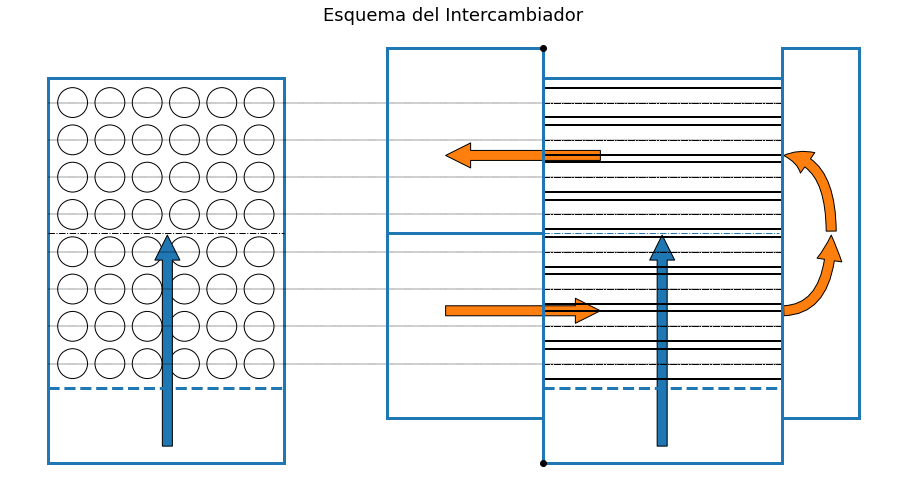

In [13]:
import matplotlib.patches as mpatches
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
escala = 1/3
coord_tubo = []

##VISTA FRONTAL
for columnai in np.arange(ncolumnas):
    yi = columnai*paso_tubos+carcasa_huelgo+Tubo_dext/2
    for filai in np.arange(nfilas):
        xi = filai*paso_tubos+carcasa_huelgo+Tubo_dext/2
        coord_tubo.append([xi,yi])
carcasa_paso = 2*Tubo_dext
fig0,ax0  = plt.subplots(figsize=(16,16))
desplazamiento_plot = -1.
#Carcasa 
lin = ax0.plot([desplazamiento_plot,desplazamiento_plot+carcasa_ymax],[0,0],linewidth=3,linestyle='dashed')
color_c = lin[0].get_color()
ax0.plot([desplazamiento_plot,desplazamiento_plot+carcasa_ymax],[carcasa_xmax,carcasa_xmax],linewidth=3,color=color_c)

ax0.plot([desplazamiento_plot,desplazamiento_plot],[0,carcasa_xmax],linewidth=3,color=color_c)

ax0.plot([desplazamiento_plot+carcasa_ymax,desplazamiento_plot+carcasa_ymax],[0,carcasa_xmax],linewidth=3,color=color_c)

#placa separadora pasaje aire
ax0.plot([desplazamiento_plot,desplazamiento_plot+carcasa_ymax],[carcasa_xmax/2,carcasa_xmax/2],linewidth=1,color='k',linestyle='dashdot')

# PATAS
ax0.plot([desplazamiento_plot,desplazamiento_plot],[-paso_tubos*2,0],linewidth=3,color=color_c)
ax0.plot([desplazamiento_plot+carcasa_ymax,desplazamiento_plot+carcasa_ymax],[-paso_tubos*2,0],linewidth=3,color=color_c)

# fondo carcasa
ax0.plot([desplazamiento_plot,desplazamiento_plot+carcasa_ymax],[-paso_tubos*2,-paso_tubos*2],linewidth=3,color=color_c)

for i,coord_tuboi in enumerate(coord_tubo):
    xi1,yi1 = coord_tuboi
    xi1 += desplazamiento_plot; 
    ax0.add_patch(plt.Circle((xi1, yi1), Tubo_dext/2, color='k',fill=False))
    
  
##VISTA LATERAL    

for i,coord_tuboi in enumerate(coord_tubo):
    xi1,yi1 = coord_tuboi
    xi1 += desplazamiento_plot; 
    ax0.plot([0,Tubo_long*escala],[yi1,yi1],color='k',linestyle='dashdot',linewidth=1)
    ax0.plot([Tubo_long*escala,desplazamiento_plot],[yi1,yi1],color='k',linestyle='dashdot',linewidth=.1)
    ax0.plot([0,Tubo_long*escala],[yi1+Tubo_dext/2,yi1+Tubo_dext/2],color='k')
    ax0.plot([0,Tubo_long*escala],[yi1-Tubo_dext/2,yi1-Tubo_dext/2],color='k')
    
ax0.set_aspect('equal')  

lin, = ax0.plot([0,Tubo_long*escala],[0,0],linewidth=3,color=color_c,linestyle='dashed')
ax0.plot([0,Tubo_long*escala],[carcasa_xmax,carcasa_xmax],linewidth=3,color=color_c)

ax0.plot([0,0],[0,carcasa_xmax],linewidth=3,color=color_c)

ax0.plot([Tubo_long*escala,Tubo_long*escala],[0,carcasa_xmax],linewidth=3,color=color_c)

ax0.plot([0,0+carcasa_ymax],[-paso_tubos*2,-paso_tubos*2],linewidth=3,color=color_c)
#placa separadora pasaje aire
ax0.plot([0,0+carcasa_ymax],[carcasa_xmax/2,carcasa_xmax/2],linewidth=1,color=color_c,linestyle='dashdot')
#PATAS
ax0.plot([0,0],[-paso_tubos*2,0],linewidth=3,color=color_c)
ax0.plot([Tubo_long*escala,Tubo_long*escala],[-paso_tubos*2,0],linewidth=3,color=color_c)

#Cabezales

alto_cabezal_salida = carcasa_xmax+Tubo_dext
alto_separador = carcasa_xmax / 2
bajo_cabezal_salida = 0-Tubo_dext
cabezal_entrada_x = -carcasa_xmax/2
cabezal_vuelta_x = carcasa_xmax/4

#cabezal entrada/salida
ax0.plot([0,cabezal_entrada_x],[alto_cabezal_salida,alto_cabezal_salida],linewidth=3,color=color_c)
ax0.plot([0,cabezal_entrada_x],[alto_separador,alto_separador],linewidth=3,color=color_c)
ax0.plot([0,cabezal_entrada_x],[bajo_cabezal_salida,bajo_cabezal_salida],linewidth=3,color=color_c)
ax0.plot([cabezal_entrada_x,cabezal_entrada_x],[bajo_cabezal_salida,alto_cabezal_salida],linewidth=3,color=color_c)
ax0.plot([0,0],[bajo_cabezal_salida,alto_cabezal_salida],linewidth=3,color=color_c)

#cabezal vuelta aire
ax0.plot([Tubo_long*escala,Tubo_long*escala],[bajo_cabezal_salida,alto_cabezal_salida],linewidth=3,color=color_c)
ax0.plot([Tubo_long*escala+cabezal_vuelta_x,Tubo_long*escala],[bajo_cabezal_salida,bajo_cabezal_salida],linewidth=3,color=color_c)
ax0.plot([Tubo_long*escala+cabezal_vuelta_x,Tubo_long*escala],[alto_cabezal_salida,alto_cabezal_salida],linewidth=3,color=color_c)

ax0.plot([Tubo_long*escala+cabezal_vuelta_x,Tubo_long*escala+cabezal_vuelta_x],[bajo_cabezal_salida,alto_cabezal_salida],linewidth=3,color=color_c)
ax0.set_axis_off()

#flecha aire tubos
arrow0 = mpatches.FancyArrowPatch((-.2, carcasa_xmax/4),(Tubo_long*escala/4,carcasa_xmax/4),
                                 mutation_scale=50,color=colors[1],ec='k')
arrow1 = mpatches.FancyArrowPatch((Tubo_long*escala/4,3*carcasa_xmax/4),(-.2, 3*carcasa_xmax/4),
                                 mutation_scale=50,color=colors[1],ec='k')
#flecha_gases lateral
arrow2 = mpatches.FancyArrowPatch((Tubo_long*escala/2,-2*Tubo_dext),(Tubo_long*escala/2, 2*carcasa_xmax/4),
                                 mutation_scale=50,color=colors[0],ec='k')
#flecha gases frontal
arrow3 = mpatches.FancyArrowPatch((Tubo_long*escala/2+desplazamiento_plot,-2*Tubo_dext),(desplazamiento_plot+Tubo_long*escala/2, 2*carcasa_xmax/4),
                                 mutation_scale=50,color=colors[0],ec='k')

arrow4 = mpatches.FancyArrowPatch((Tubo_long*escala, carcasa_xmax/4),
                                  (Tubo_long*escala+0.1, 2*carcasa_xmax/4),mutation_scale=50,color=colors[1],ec='k',connectionstyle="angle3, angleA=0, angleB=90")
arrow5 = mpatches.FancyArrowPatch((Tubo_long*escala+0.1, carcasa_xmax/2),
                                  (Tubo_long*escala+0., 3*carcasa_xmax/4),mutation_scale=50,color=colors[1],ec='k',connectionstyle="angle3, angleA=90, angleB=0")

ax0.add_patch(arrow0)
ax0.add_patch(arrow1)
ax0.add_patch(arrow2);
ax0.add_patch(arrow3);
ax0.add_patch(arrow4);
ax0.add_patch(arrow5);
ax0.set_title('Esquema del Intercambiador',fontsize=18);

ax0.plot(0,-paso_tubos*2,'ko')
ax0.plot(0,alto_cabezal_salida,'ko')

E Cao, 2009, pag 139

In [14]:
display(Latex(f'Alto equipo: {alto_cabezal_salida*1e3-(-paso_tubos*2*1e3):.0f} mm,Ancho equipo {1e3*carcasa_ymax+2*Tubo_dext*1e3:.0f} mm, Largo equipo:{Tubo_long-cabezal_entrada_x+cabezal_vuelta_x:.2f} m'))

display(Latex(f'Largo tubos: {Tubo_long:} m'))

display(Latex(f'Placa tubos alto: {1e3*(carcasa_xmax-(-paso_tubos*2) ):.0f} mm , ancho: {carcasa_ymax*1e3:.0f} mm'))

display(Latex(f'Placa separadora largo: {-1e3*(cabezal_entrada_x):.0f} , ancho: {carcasa_ymax*1e3:.0f}'))

espesor_chapa1 = 3
espesor_chapa2 = 25.4*1/4
display(Latex(f'Chapa espesor:%.2f mm, Chapa espesor portatubos:%.2f mm'%(espesor_chapa1,espesor_chapa2)))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [15]:
carca

NameError: name 'carca' is not defined

## Cálculo de Chimenea

#### Dimensiones


In [16]:
gases_chimenea = fluido_intercambiador('Gases chimenea') 
gases_chimenea.temp_entrada = Gases.temp_salida
gases_chimenea.temp_salida = 20

L_chimenea = 5 #m
D_chimenea = 0.25 #m
veloc_chimenea = Gases.caudal/(D_chimenea**2/4*np.pi)*Gases.rho/gases_chimenea.rho
Re_chimenea = veloc_chimenea * D_chimenea/gases_chimenea.nu
e = 0.15 # mm para hierro galvanizado
rug_relativa = e*1e-3/D_chimenea
f_f = ht.conv_internal.friction_factor(Re_chimenea, rug_relativa)
P_ca= f_f*Gases.rho*(L_chimenea/D_chimenea)*(veloc_chimenea**2/2)
# Pérdidas en accesorios
k_salida_expansion = 0.8
k_entrada_contraccion = 0.4
k_lcodo = 16 * f_f
k_lt = 60 * f_f
k_localizadas = 2*k_lcodo + k_lt+k_salida_expansion + k_entrada_contraccion
P_acc = k_localizadas * gases_chimenea.rho * veloc_chimenea**2/2


P_tiraje = gases_chimenea.rho*g*(400-20)/373*L_chimenea


In [17]:
display(Latex(f'Alto chimenea: L={L_chimenea:.2f} m'))
display(Latex(f'Diámetro chimenea: D={D_chimenea:.2f} m'))
display(Latex(f'Velocidad chimenea: V={veloc_chimenea:.2f} m/s'))
display(Latex(f'Reynolds chimenea: Re={Re_chimenea:.0f}'))
display(Latex(f'Factor de fricción chimenea: $f_f$={f_f:.5f}'))
display(Latex(f'Pérdidas fricción chimenea: $\Delta p_L$={P_ca:.1f} Pa'))
display(Latex(f'Pérdidas Localizadas chimenea: $\Delta p_L$={P_acc:.1f} Pa'))
display(Latex(f'Pérdidas intercambiador: $\Delta p_T=\\rho g\Delta T\\beta L$={Gases.DeltaP:.1f} Pa'))
display(Latex(f'Pérdidas totales: $\Delta p$={Gases.DeltaP+P_acc+P_ca:.1f} Pa'))
display(Latex(f'Tiraje chimenea: $\Delta p_T=\\rho g\Delta T\\beta L$={P_tiraje:.1f} Pa'))



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Pérdidas en el Circuito Aire

Filtro

entrada al intercambiador

friccion tubos

paso tubos

salida del intercambiador

entrada a batea

paso por batea

perdidas mandioca


In [18]:
Lado_ventilador = 30e-2
Diam_zingueria = 25e-2
velocidad_ventilador = Aire.caudal / Lado_ventilador**2
k_expansion = 0.8
dp_expansion_entrada_intercambiador  = Aire.rho*velocidad_ventilador**2/2*k_expansion
dp_intercambiador =  Aire.DeltaP
k_contraccion = 0.4
velocidad_aire_salida_intercambiador = Aire.caudal/(carcasa_xmax/2*carcasa_ymax)
dp_contraccion_salida_intercambiador  = Aire.rho*velocidad_aire_salida_intercambiador**2/2*k_contraccion
veloc_aire_zingueria = Aire.caudal/ (Diam_zingueria**2/4*np.pi)
dp_expansion_entrada_batea  = Aire.rho*veloc_aire_zingueria**2/2*k_expansion

dp_total = dp_expansion_entrada_intercambiador+dp_intercambiador+dp_contraccion_salida_intercambiador+dp_expansion_entrada_batea

dp_expansion_entrada_intercambiador,dp_total


(45.05286964583073, 272.9066135741818)

In [19]:
Diam_batea = 1.2
Radio_agujeritos = 0.306
Area_agujeritos = np.pi*Radio_agujeritos**2
Area_batea = np.pi*Diam_batea**2/4
Aire.caudal/Area_agujeritos

3.0816078917156835

In [20]:
#Dimensiones Desde el CAD
#Volumenes
Tubos_vol = (Tubo_dext**2-Tubo_dint**2)*np.pi/4*Tubo_long * Ntubos_0
Placas_porta_vol = 3* (477*1000*6)
Placas_laterales_vol = 2* (1000*1920*3)
Placas_separadora_vol = (320*477*3)
Placa_base_vol = 2*(1920*477*3)

Volumen_total = Tubos_vol*1e9 + Placa_base_vol+Placas_laterales_vol + Placas_porta_vol
rho_acero = 7800 #kg/m3

Peso_total = Volumen_total*(1e-3)**3 * rho_acero
display(Latex(f'Peso_total = {Peso_total:.0f} kg'))

<IPython.core.display.Latex object>

In [21]:
Tubos_vol*7800,Placa_base_vol*7800e-9,Placas_laterales_vol*7.8e-6

(198.86221178644428, 42.861312, 89.856)

In [22]:
Tubo_dint

0.0563